In [1]:
%matplotlib inline

In [1]:
import time
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
from data_loader import pytorch_dataloader
import torch
import torchvision as tv
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import PIL
import random

plt.ion() 

In [8]:
# mean = [0.485, 0.456, 0.406]
# std = [0.229, 0.224, 0.225]
mean = [0,0,0]
std = [1, 1, 1]
pic_size = (224,224)
loader_gen = pytorch_dataloader(mean = mean, std = std)
img_transform = tv.transforms.Compose([
                tv.transforms.RandomResizedCrop(pic_size),
                tv.transforms.RandomHorizontalFlip(),
                tv.transforms.ToTensor(),
                tv.transforms.Normalize(mean, std)
            ])
dataloaders, dataset_sizes, character_names, img_transform = loader_gen.gen_loader(data_transforms=img_transform, batch_size=8)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: {}".format(device))

Character names: ['illyasviel_von_einzbern', 'mato_sakura', 'misaka_mikoto', 'rider_medusa', 'saber_arutoria_pendoragon', 'tohsaka_rin', 'violet_evergarden']
Using device: cuda:0


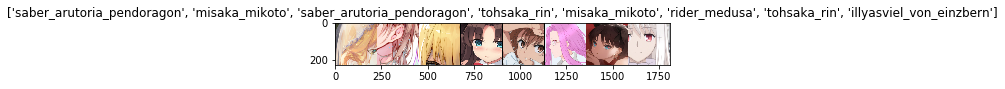

In [9]:
inputs, classes = next(iter(dataloaders['train']))
out = tv.utils.make_grid(inputs)

loader_gen.loader_display(out, title=[character_names[x] for x in classes])

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [17]:
models = {
    'rn18' : tv.models.resnet18(pretrained=True),
    'rn34' : tv.models.resnet34(pretrained=True),
    'rn50' : tv.models.resnet50(pretrained=True),
    'rn101' : tv.models.resnet101(pretrained=True)
}
for key in models.keys():
    model = models[key]
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, len(character_names))
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
    print("[STATUS] start training model: {}".format(key))
    model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

[STATUS] start training model: rn18
Epoch 0/4
----------
train Loss: 1.2290 Acc: 0.5807
test Loss: 0.5354 Acc: 0.8365

Epoch 1/4
----------
train Loss: 0.4758 Acc: 0.8465
test Loss: 0.4791 Acc: 0.8491

Epoch 2/4
----------
train Loss: 0.3443 Acc: 0.8861
test Loss: 0.3015 Acc: 0.9119

Epoch 3/4
----------
train Loss: 0.3027 Acc: 0.9035
test Loss: 0.2663 Acc: 0.8868

Epoch 4/4
----------
train Loss: 0.2184 Acc: 0.9399
test Loss: 0.2590 Acc: 0.9182

Training complete in 0m 27s
Best val Acc: 0.918239
[STATUS] start training model: rn34
Epoch 0/4
----------
train Loss: 1.1930 Acc: 0.5934
test Loss: 0.5453 Acc: 0.8113

Epoch 1/4
----------
train Loss: 0.3851 Acc: 0.8734
test Loss: 0.3520 Acc: 0.8994

Epoch 2/4
----------
train Loss: 0.3665 Acc: 0.8924
test Loss: 0.3295 Acc: 0.8994

Epoch 3/4
----------
train Loss: 0.2020 Acc: 0.9478
test Loss: 0.1997 Acc: 0.9497

Epoch 4/4
----------
train Loss: 0.2883 Acc: 0.8987
test Loss: 0.1906 Acc: 0.9245

Training complete in 0m 37s
Best val Acc: 0.949

In [16]:
# model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

In [18]:
def random_visualization(model):
    model.eval()
    modeling_data_path = os.path.join('data_set', 'modeling_data')
    characters_folders = os.listdir(modeling_data_path)
    for character in characters_folders:
        pic_folder = os.path.join(modeling_data_path, character)
        all_pics = os.listdir(pic_folder)
        sampling = random.choices(all_pics, k=2)
        for pic in sampling:
            pic_dir = os.path.join(pic_folder, pic)
            raw_img = PIL.Image.open(pic_dir).convert('RGB')
            img = img_transform(raw_img).float()
            img = torch.autograd.Variable(img, requires_grad=True)
            img = img.unsqueeze(0).cuda()
            outputs = model(img)
            _, preds = torch.max(outputs, 1)
            pred_result = character_names[preds[0]]
            plt.imshow(raw_img)
            plt.title("Prediction: {}, Truth: {}, Corret: {}".format(pred_result, character, pred_result == character))
            plt.show()

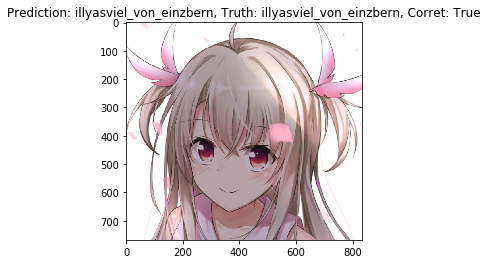

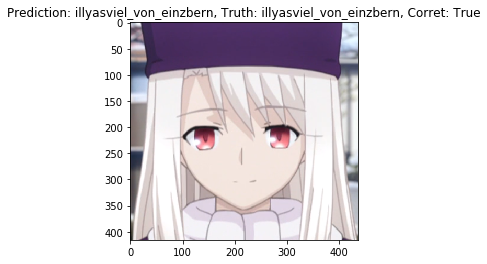

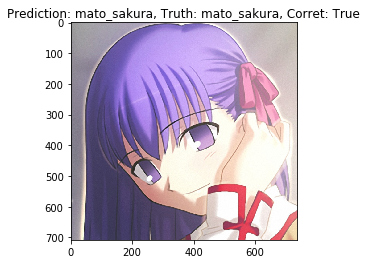

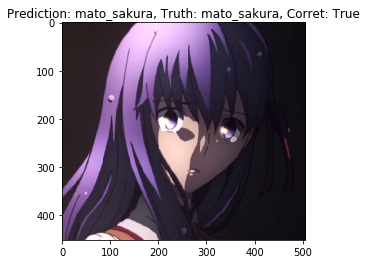

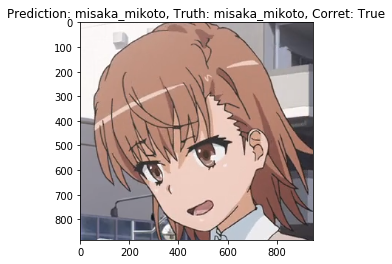

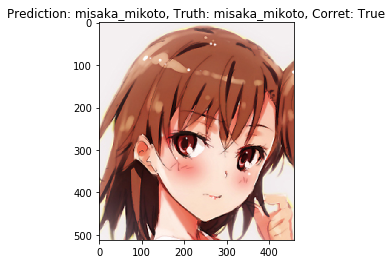

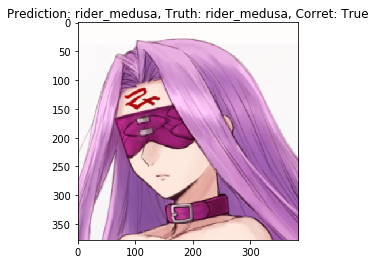

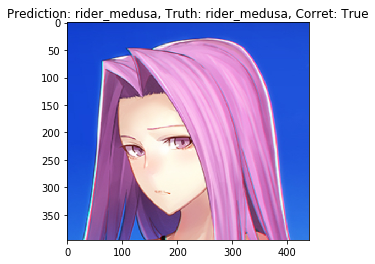

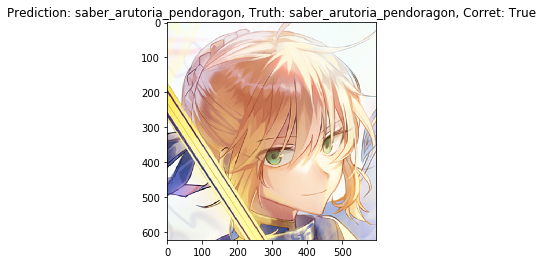

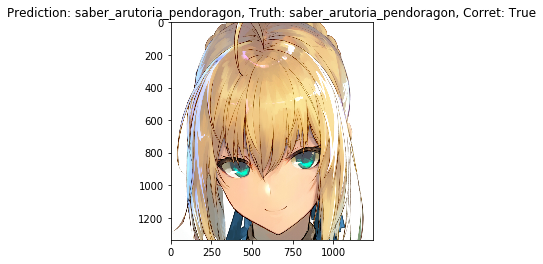

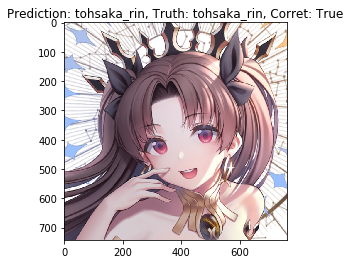

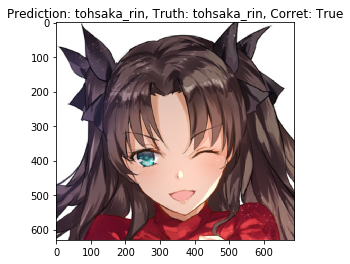

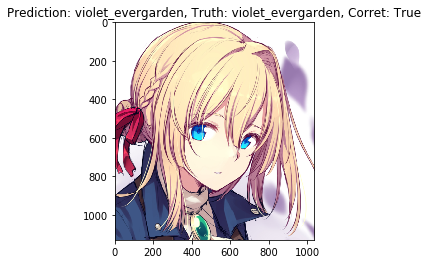

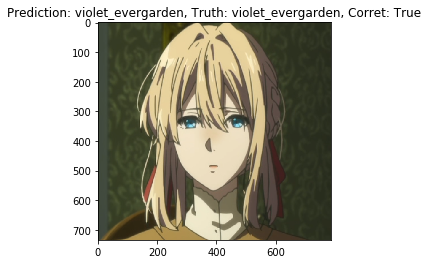

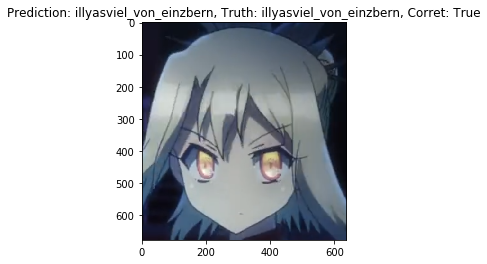

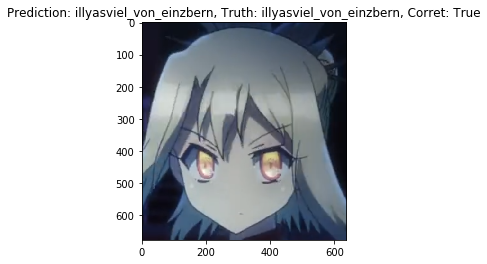

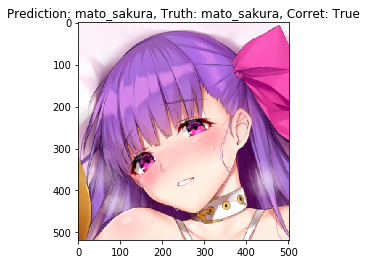

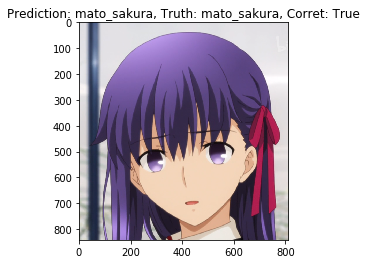

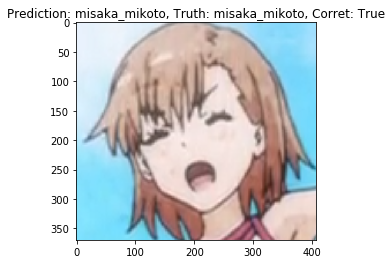

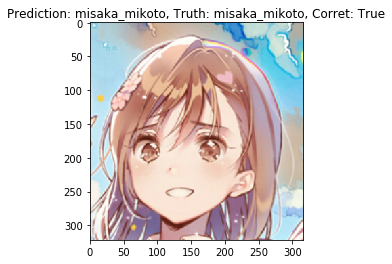

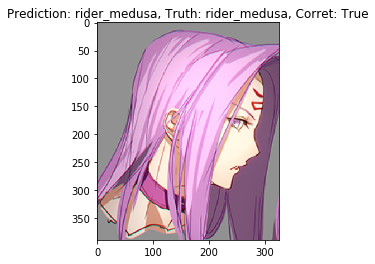

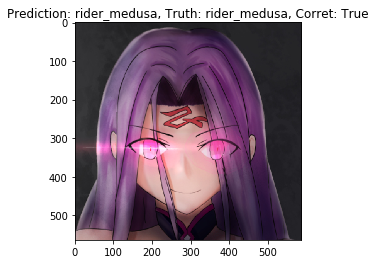

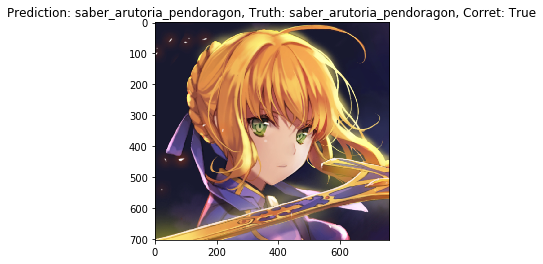

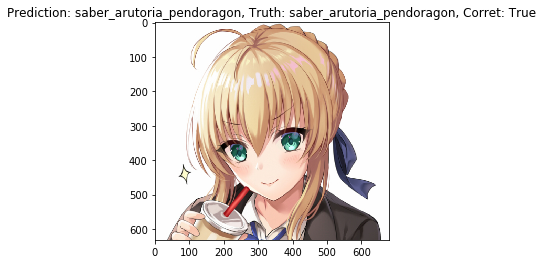

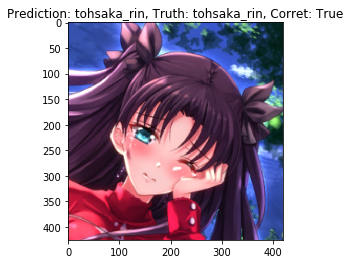

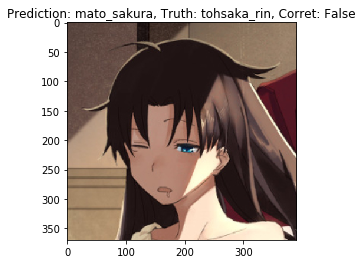

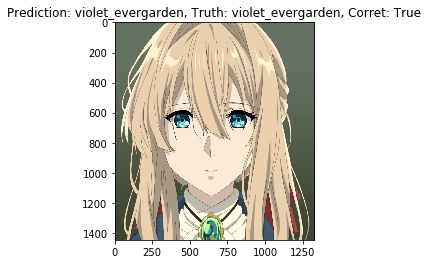

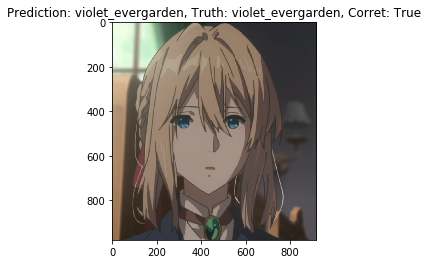

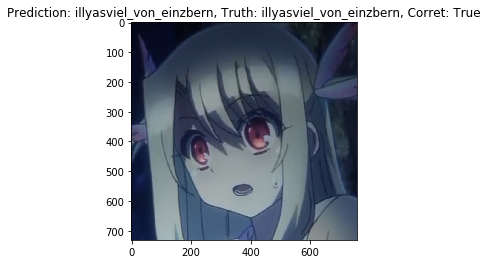

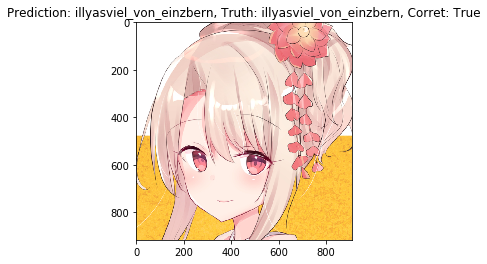

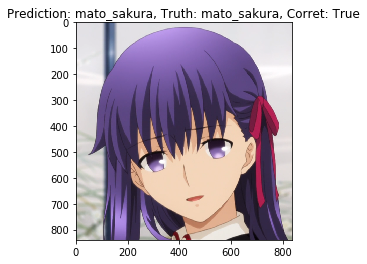

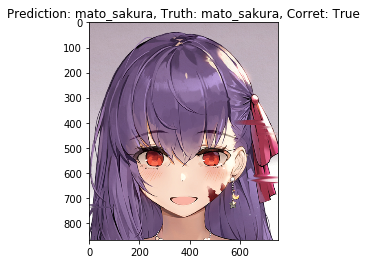

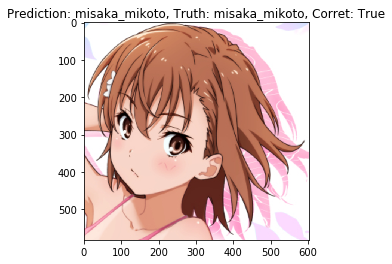

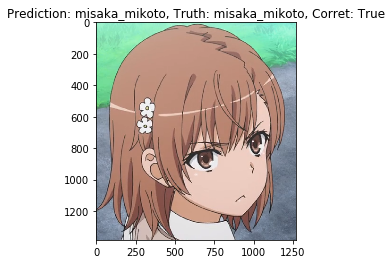

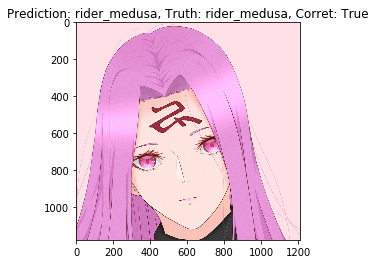

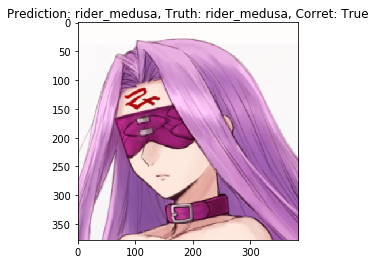

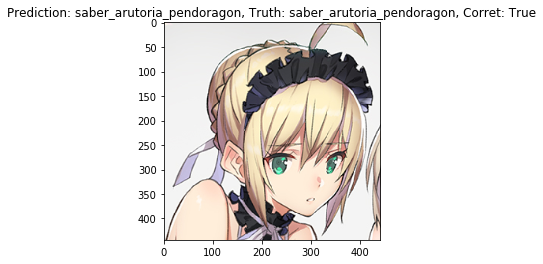

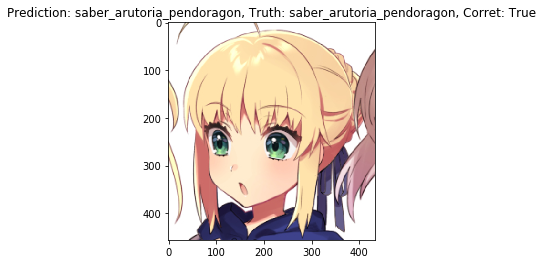

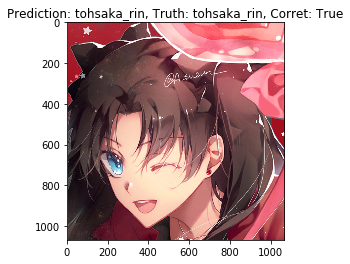

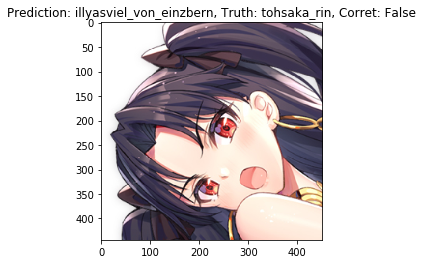

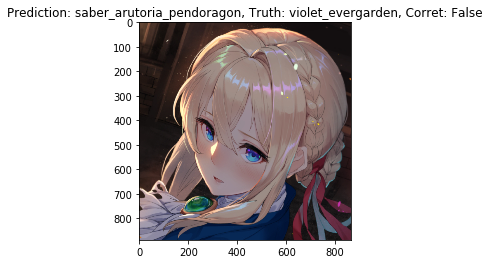

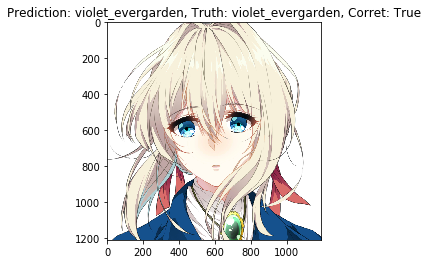

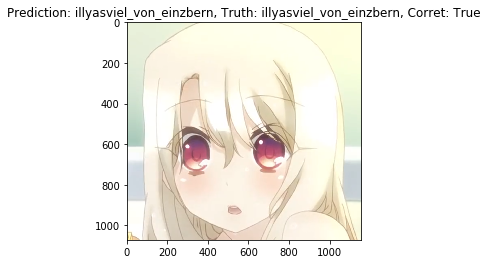

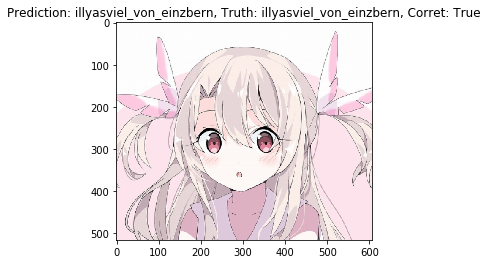

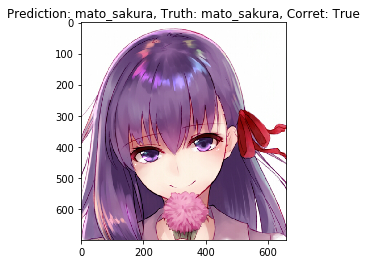

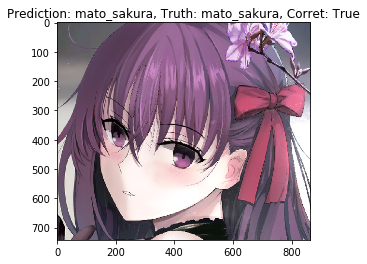

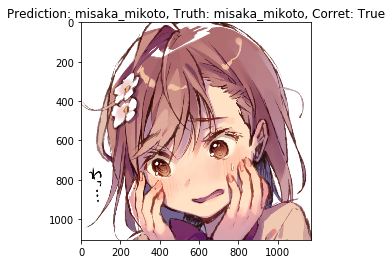

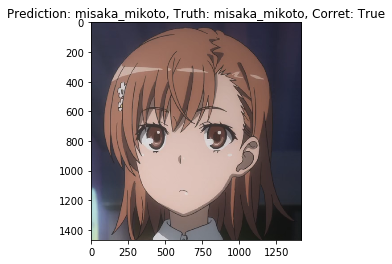

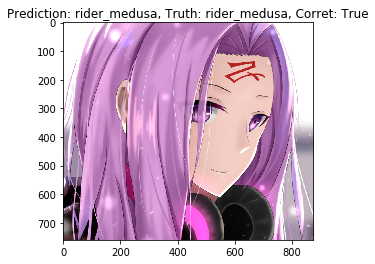

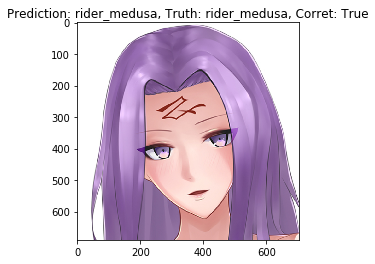

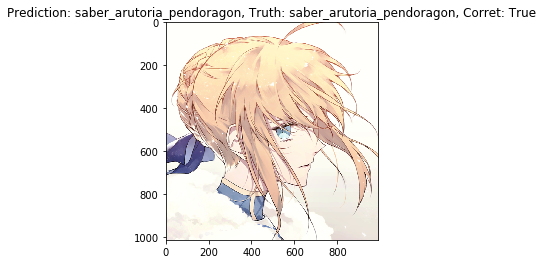

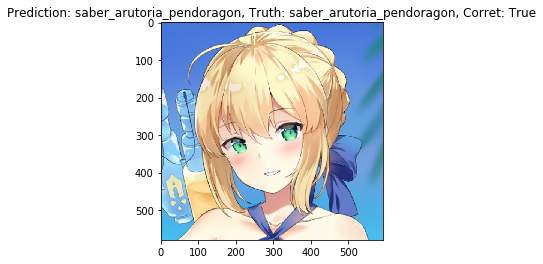

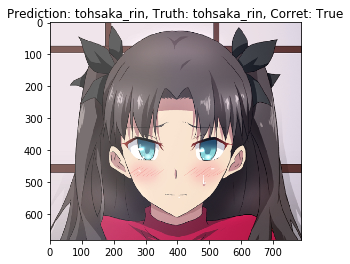

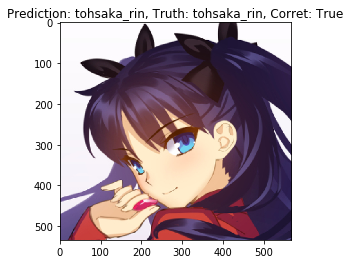

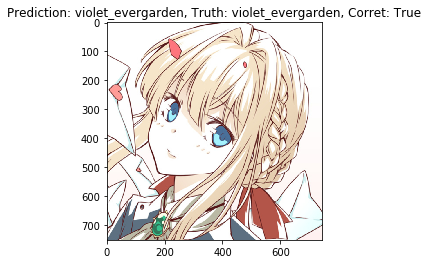

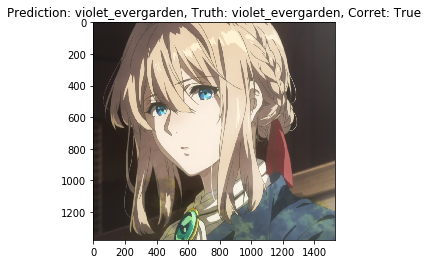

In [19]:
for key in models.keys():
    random_visualization(models[key])

In [22]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(character_names[preds[j]]))
                loader_gen.loader_display(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

model name: rn18


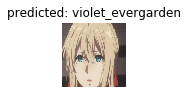

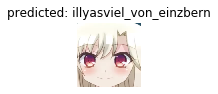

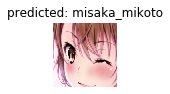

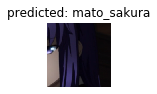

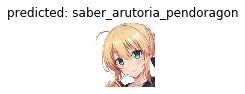

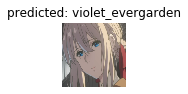

model name: rn34


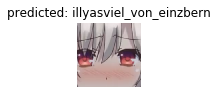

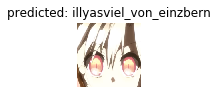

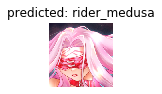

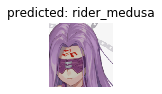

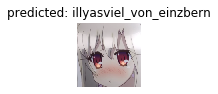

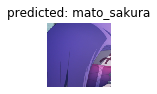

model name: rn50


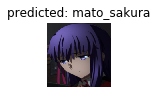

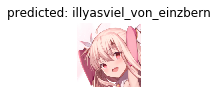

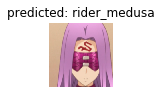

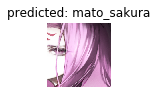

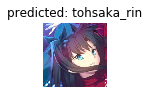

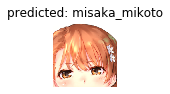

model name: rn101


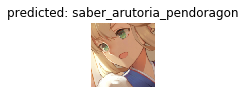

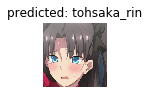

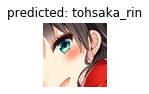

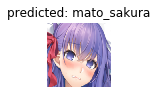

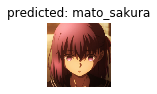

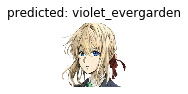

In [23]:
for key in models.keys():
    print("model name: {}".format(key))
    visualize_model(models[key])